In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

from pyspark.ml.clustering import KMeans, KMeansSummary

from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
#env variables
write_files = True
fit_model = True
model_path = "file:///home/work/data/kmeans_movies_model"

In [3]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'KMEANS Clustering')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-27 03:00:50,770 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-05-27 03:00:51,444 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-05-27 03:00:51,444 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2022-05-27 03:00:51,444 WARN util.Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
train_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_train.csv", inferSchema=True)
test_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_test.csv", inferSchema=True)


# READ IN OLD STUFF
#TODO REMOVE
# df = spark.read.option("header",True).csv("file:///home/work/data/final_movies_df_10.csv", inferSchema=True)
# train_df, test_df = df.randomSplit([0.8, 0.1], seed=0)

In [5]:
col_names = train_df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
feat_cols = sorted(list(set(col_names).difference(set(exc_cols))))
feat_cols

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'avg_rating']

In [6]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features', handleInvalid='skip')
train = assembler.transform(train_df)
test = assembler.transform(test_df)
train.show(5)

2022-05-27 03:00:56,633 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|movieId|               title|        avg_rating|movieYear|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|            features|
+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|      1|    Toy Story (1995)| 3.893707794587238|     1995|Adventure|Animati...|  0.0|    0.0|     0.0|      1.0|  0.0|0.0|        0.0|    1.0|    0.0|    0.0|      1.0|      0.0|   0.0|    0.0|   1.0|     1.0|   0.0|   0.0|(19,[1,2,3,4,8,18...|
| 100008|    Fla

In [7]:
tvsModel = TrainValidationSplitModel.read().load(model_path)
cluster_list = list(range(10,1501,10))
evaluator = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')


In [8]:
%%time
evaluator.evaluate(tvsModel.transform(train))

CPU times: user 13.6 ms, sys: 6.26 ms, total: 19.8 ms
Wall time: 14.7 s


0.6355963350995041

In [9]:
%%time
evaluator.evaluate(tvsModel.transform(test))

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 2.78 s


0.5725490613357676

K: 140 cosine score: 0.6029447511074769
K: 1350 cosine score: 0.6031929712453477


Text(0.5, 1.0, 'Score Dependence on Total Clusters')

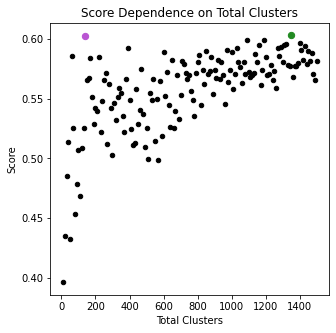

In [10]:
plt.figure(figsize=(5,5))
scores_i = np.where(np.array(tvsModel.validationMetrics) >= 0.6)[0]
plt.scatter(cluster_list, tvsModel.validationMetrics, color='black', s=20)
colors = ['mediumorchid','forestgreen']
for i, s_i in enumerate(scores_i):
    s_k = (s_i + 1) * 10
    print(f'K: {s_k} cosine score: {tvsModel.validationMetrics[s_i]}')
    plt.scatter(s_k, tvsModel.validationMetrics[s_i], color=colors[i], s=40)
plt.ylabel('Score')
plt.xlabel('Total Clusters')
plt.title('Score Dependence on Total Clusters')

0.6029447511074769


Train eval with 140 clusters: Train: 0.5352356173647969 Test: 0.540881080013947
Clusters with less than 10 observations: 2
0.6031929712453477


Train eval with 1350 clusters: Train: 0.6355963350995041 Test: 0.5725490613357676
Clusters with less than 10 observations: 968
CPU times: user 345 ms, sys: 70.7 ms, total: 416 ms
Wall time: 2min 23s


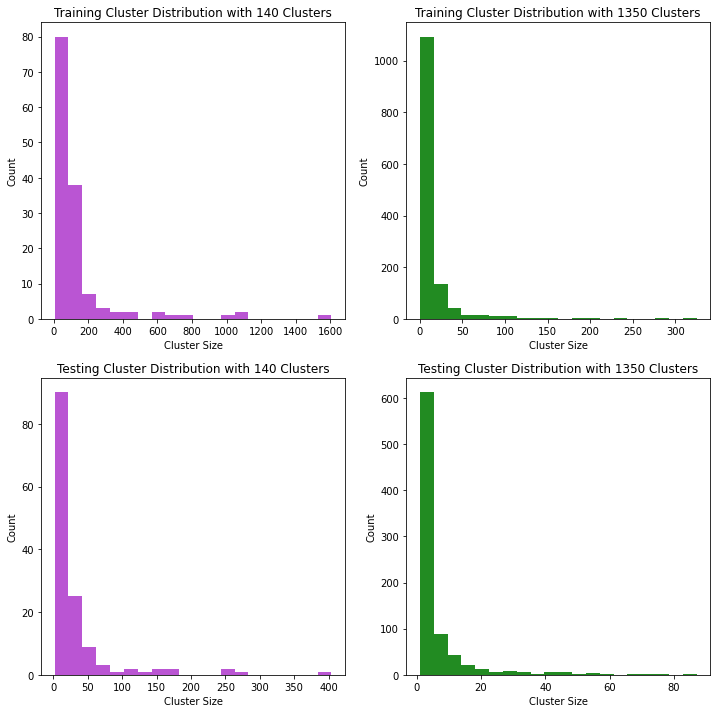

In [11]:
%%time
plt.figure(figsize=(12,12))
train_i = 1
test_i = 3
for i, s_i in enumerate(scores_i):
    print(tvsModel.validationMetrics[s_i])
    s_k = (s_i + 1) * 10
    kmeans = KMeans(k=s_k, featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
    mood = kmeans.fit(train)
    s_k_train = evaluator.evaluate(mood.transform(train))
    s_k_test = evaluator.evaluate(mood.transform(test))
    small_clusters = np.where(np.array(mood.summary.clusterSizes) <= 10)[0]
    tot_small = len(small_clusters)
    print(f"Train eval with {s_k} clusters: Train: {s_k_train} Test: {s_k_test}")
    print(f"Clusters with less than 10 observations: {tot_small}")
    # plot train
    plt.subplot(2,2,train_i)
    _, _, _ = plt.hist(mood.summary.clusterSizes,bins=20,color=colors[i])
    plt.title(f'Training Cluster Distribution with {s_k} Clusters')
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    # plot test
    transformed = mood.transform(test)
    h = transformed.select('prediction').groupBy('prediction').count()
    h = h.select('count').toPandas()
    plt.subplot(2,2,test_i)
    _, _, _ = plt.hist(h['count'],bins=20,color=colors[i])
    plt.title(f'Testing Cluster Distribution with {s_k} Clusters')
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    # update plot counters
    train_i = train_i + 1
    test_i = test_i + 1

In [12]:
%%time
k = (scores_i[0] + 1) * 10
kmeans = KMeans(k=k, featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
mood = kmeans.fit(train)

CPU times: user 7.66 ms, sys: 3.79 ms, total: 11.4 ms
Wall time: 2.28 s


In [13]:
b = mood.summary.predictions.select('genres', 'prediction').groupBy('genres', 'prediction').count()
large_clusters = np.where(np.array(mood.summary.clusterSizes) >= 900)[0]
large_clusters

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([  2,  21,  89, 125])

In [14]:
b = mood.summary.predictions.select('genres', 'prediction').groupBy('genres', 'prediction').count()
print(1)
b.filter(b.prediction == 1).select('genres','count').show(truncate=False)
for l in large_clusters:
    print(l)
    b.filter(b.prediction == int(l)).select('genres','count').show(truncate=False)

1
+---------------------------+-----+
|genres                     |count|
+---------------------------+-----+
|Action|Comedy|Crime|Romance|4    |
|Action|Comedy|Crime|Horror |1    |
|Action|Comedy|Crime|Western|1    |
|Action|Comedy|Crime|Mystery|1    |
|Action|Comedy|Crime        |60   |
+---------------------------+-----+

2
+-----------------+-----+
|genres           |count|
+-----------------+-----+
|Documentary|Drama|39   |
|Drama            |973  |
+-----------------+-----+

21
+------------------+-----+
|genres            |count|
+------------------+-----+
|Comedy|War|Western|1    |
|Comedy|Mystery    |5    |
|Comedy            |1012 |
|Comedy|War        |15   |
|Comedy|Western    |29   |
+------------------+-----+

89
+------+-----+
|genres|count|
+------+-----+
|Drama |1606 |
+------+-----+

125
+---------------------------+-----+
|genres                     |count|
+---------------------------+-----+
|Animation|Documentary      |7    |
|Documentary|Fantasy        |1    |
|Doc

In [15]:
transformed = mood.transform(test)
print(1)
bb = transformed.select('genres', 'prediction').groupBy('genres', 'prediction').count()
bb.filter(bb.prediction == 1).select('genres','count').show(truncate=False)
for l in large_clusters:
    print(l)
    bb.filter(bb.prediction == int(l)).select('genres','count').show(truncate=False)

1
+---------------------------+-----+
|genres                     |count|
+---------------------------+-----+
|Action|Comedy|Crime|Romance|1    |
|Action|Comedy|Crime        |9    |
+---------------------------+-----+

2
+-----------------+-----+
|genres           |count|
+-----------------+-----+
|Documentary|Drama|4    |
|Drama            |244  |
+-----------------+-----+

21
+--------------+-----+
|genres        |count|
+--------------+-----+
|Comedy|Mystery|5    |
|Comedy        |257  |
|Comedy|War    |4    |
|Comedy|Western|10   |
+--------------+-----+

89
+------+-----+
|genres|count|
+------+-----+
|Drama |404  |
+------+-----+

125
+---------------------+-----+
|genres               |count|
+---------------------+-----+
|Animation|Documentary|1    |
|Documentary|Fantasy  |1    |
|Documentary          |240  |
|Crime|Documentary    |4    |
|Documentary|Thriller |1    |
|Adventure|Documentary|2    |
|Documentary|Sci-Fi   |1    |
+---------------------+-----+



In [17]:
spark.stop()